# Inventory Dynamics

Seho Jeong, Sogang University

**References**
- QuantEcon

In [79]:
# Import libraries.
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, lax

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from typing import NamedTuple
from time import time

In [18]:
# Customized colors
bg = '#F9F9F9'

In [3]:
# Assume that each D_t is lognormal: D_t = exp(μ + σ Z_t).
# Define a `namedtuple` that stores parameters.
class ModelParameters(NamedTuple):
    s: int = 10
    S: int = 100
    μ: float = 1.0
    σ: float = 0.5

## Cross-Section of Inventory

In [4]:
@jax.jit
def update_cross_section(params: ModelParameters,
                         X_vec: jnp.ndarray,
                         D_vec: jnp.ndarray) -> jnp.ndarray:
    """ 
    Update by one period a cross-section of firms with inventory levels given by X_vec, given the vector of demand shocks in D_vec. 
    Here, D[i] is the demand shock for firm i with current inventory X_vec[i].
    """
    # Unpack
    s, S = params.s, params.S

    # Restock if the inventory is below the threshold.
    X_new = jnp.where(X_vec <= s,
                      jnp.maximum(S - D_vec, 0),
                      jnp.maximum(X_vec - D_vec, 0))
    
    return X_new

In [8]:
# Given the initial distribution taking all firms to have initial inventory `x_init`, 
# I compute the cross-sectional distribution at T > 0.
def project_cross_section(params: ModelParameters,
                          x_init: jnp.ndarray,
                          T: int,
                          key: jnp.ndarray,
                          num_firms: int = 50_000) -> jnp.ndarray:
    # Set up initial distribution.
    X_vec = jnp.full((num_firms, ), x_init)

    # Update cross-section.
    for t in range(T):
        Z = random.normal(key, shape=(num_firms, ))
        D = jnp.exp(params.μ + params.σ * Z)

        X_vec = update_cross_section(params, X_vec, D)
        _, key = random.split(key)
    
    return X_vec

In [13]:
# Use the baseline specification.
params = ModelParameters()
x_init = 50
T = 500

# Initialize random number generator.
key = random.PRNGKey(1)

In [47]:
%time 
X_vec = project_cross_section(params, x_init, T, key).block_until_ready()

CPU times: user 1e+03 ns, sys: 2 μs, total: 3 μs
Wall time: 5.01 μs


In [53]:
# We can gain speed by compiling the outer loop.
def project_cross_section_fori(params: ModelParameters,
                               x_init: int,
                               T: int,
                               key: jnp.ndarray,
                               num_firms: int = 50_000) -> jnp.ndarray:
    # Unpack parameters.
    s, S, μ, σ = params.s, params.S, params.μ, params.σ
    X = jnp.full((num_firms, ), x_init)

    # Define the function for each update.
    def fori_update(t, loop_state):
        # Unpack
        X, key = loop_state

        # Draw shocks using key.
        Z = random.normal(key, shape=(num_firms, ))
        D = jnp.exp(μ + σ * Z)

        # Update X.
        X = jnp.where(X <= s,
                      jnp.maximum(S - D, 0),
                      jnp.maximum(X - D, 0))
        
        # Refresh the key.
        _, subkey = random.split(key)

        return X, subkey
    
    # Loop t from 0 to T, applying fori_update each time.
    initial_loop_state = X, key
    X, key = lax.fori_loop(0, T, fori_update, initial_loop_state)
    return X

In [58]:
%time
X_vec_fori = project_cross_section_fori(params, x_init, T, key).block_until_ready()

CPU times: user 1 μs, sys: 1e+03 ns, total: 2 μs
Wall time: 3.1 μs


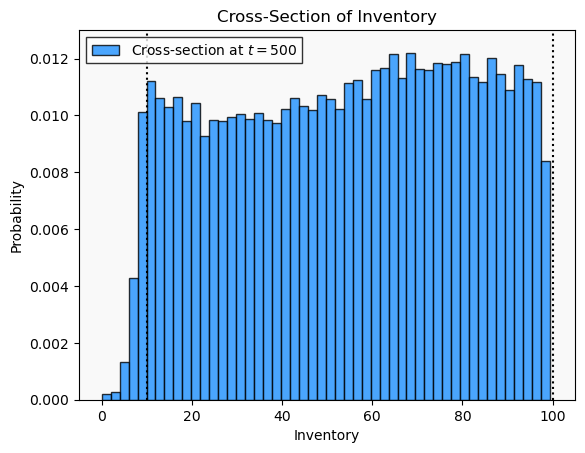

In [59]:
# Plot a histogram of inventory levels at time T.
fig, ax = plt.subplots()

ax.hist(X_vec,
        bins=50,
        density=True, 
        color='dodgerblue',
        edgecolor='k',
        alpha=0.8,
        label=f'Cross-section at $t = {T}$')

ax.vlines(x=[params.s, params.S],
          ymin=0, 
          ymax=0.013,
          colors='k',
          linestyles=':')

ax.legend(fancybox=False, edgecolor='k')
ax.set_title('Cross-Section of Inventory')
ax.set_facecolor(bg)
ax.set_ymargin(0)
ax.set_xlabel('Inventory')
ax.set_ylabel('Probability')

plt.show()

## Distribution Dynamics

In [61]:
# We now look at how the sequence of distributions evolves over time.
def shift_forward_and_sample(x_init: int, 
                             params: ModelParameters, 
                             sample_dates, 
                             key: jnp.ndarray, 
                             num_firms: int =50_000, 
                             sim_length: int =750) -> jnp.ndarray:
    # Initialize parameters.
    s, S, μ, σ = params.s, params.S, params.μ, params.σ
    X = res = jnp.full((num_firms, ), x_init)

    # Use for loop to update X and collect samples.
    for t in range(sim_length):
        Z = random.normal(key, (num_firms, ))
        D = jnp.exp(μ + σ * Z)

        X = update_cross_section(params, X, D)
        _, key = random.split(key)

        # Draw a sample at the sample dates.
        if (t+1 in sample_dates):
            res = jnp.vstack((res, X))
    
    return res[1:]

In [63]:
# Test it using baseline specification.
sample_dates = 10, 50, 250, 500, 750
X = shift_forward_and_sample(x_init, params, sample_dates, key)

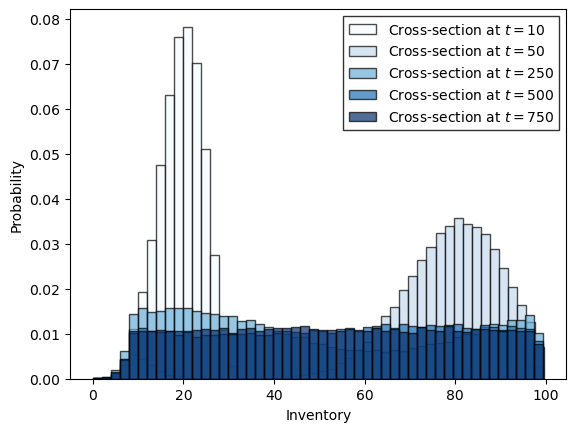

In [88]:
# Plot the output for distribution dynamics.
fig, ax = plt.subplots()

# Set colors.
norm = plt.Normalize(vmin=0, vmax=len(sample_dates)-1)

for t, date in enumerate(sample_dates):
    counts, bins, patches = ax.hist(X[t, :], 
                                    bins=50, 
                                    density=True, 
                                    edgecolor='k', 
                                    alpha=0.7,
                                    color=cm.Blues(norm(t)),
                                    label=f'Cross-section at $t={date}$')

    
ax.legend(fancybox=False, edgecolor='k')
ax.set_xlabel('Inventory')
ax.set_ylabel('Probability')

plt.show()

## Restock Frequency

In [119]:
@jax.jit
def update_stock(n_restock, X, params, D):
    n_restock = jnp.where(X <= params.s,
                          n_restock + 1,
                          n_restock)
    X = jnp.where(X <= params.s,
                  jnp.maximum(params.S - D, 0),
                  jnp.maximum(X - D, 0))
    return n_restock, X, key

def compute_freq(params, 
                 key,
                 x_init=70,
                 sim_length=50,
                 num_firms=1_000_000):
    
    # Prepare initial arrays.
    X = jnp.full((num_firms, ), x_init)

    # Stack the restock counter on top of the inventory.
    n_restock = jnp.zeros((num_firms, ))

    # Use a for loop to perform the calculations on all states.
    for t in range(sim_length):
        Z = random.normal(key, (num_firms, ))
        D = jnp.exp(params.μ + params.σ * Z)
        n_restock, X, key = update_stock(n_restock, X, params, D)
        key = random.fold_in(key, t)

    return jnp.mean(n_restock > 1, axis=0)


def compute_freq_fori(params, 
                      key, 
                      x_init=70,
                      sim_length=50,
                      num_firms=1_000_000):
    
    # Prepare initial arrays.
    X_init = jnp.full((num_firms, ), x_init)
    n_restock_init = jnp.zeros((num_firms, ))
    
    init = (n_restock_init, X_init, key)

    def update_fori(t, output):
        n_restock, X, key = output

        # Update restock counts.
        n_restock = jnp.where(X <= params.s,
                              n_restock + 1,
                              n_restock)
        
        # Draw shocks and update inventory.
        Z = random.normal(key, shape=(num_firms, ))
        D = jnp.exp(params.μ + params.σ * Z)
        X = jnp.where(X <= params.s,
                      jnp.maximum(params.S - D, 0),
                      jnp.maximum(X - D, 0))
        
        # Update key.
        key = random.fold_in(key, t)

        return n_restock, X, key
    
    n_restock, X, key = lax.fori_loop(0, sim_length, update_fori, init)

    return jnp.mean(n_restock > 1, axis=0)
    


In [120]:
key = random.PRNGKey(27)

In [123]:
%time
freq = compute_freq(params, key).block_until_ready()
print(f'Computed restock frequency = {freq:.7f}')

CPU times: user 1e+03 ns, sys: 2 μs, total: 3 μs
Wall time: 5.01 μs
Computed restock frequency = 0.4477230


In [124]:
%time
freq = compute_freq_fori(params, key).block_until_ready()
print(f'Computed restock frequency = {freq:.7f}')

CPU times: user 1 μs, sys: 2 μs, total: 3 μs
Wall time: 6.2 μs
Computed restock frequency = 0.4470170
